<a href="https://colab.research.google.com/github/dmunger27/dental-xray-segmentation/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cloudpathlib
!pip install boto3
!pip install tensorflow
!pip install pillow
!pip install opencv-python
!pip install focal_loss
!pip install albumentations

In [27]:
import os
import shutil
import pandas as pd
import numpy as np
from cloudpathlib import CloudPath
from cloudpathlib import S3Client
from cloudpathlib import S3Path
import matplotlib.pyplot as plt
import boto3
import glob
import PIL
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from focal_loss import BinaryFocalLoss
from sklearn.model_selection import train_test_split
import albumentations as A
import random
from keras import backend as K
from keras.constraints import max_norm


In [3]:
# Set environment variables
key_data = pd.read_csv('rootkey.csv')
#os.environ['AWS_ACCESS_KEY'] = ''
#os.environ['AWS_SECRET_KEY'] = ''

## Load and Prepare Data

In [4]:
# Create files in local storage for x-ray data

def gatherS3Data(s3_path, folder_name):
  s3_client = S3Client(aws_access_key_id=os.getenv('AWS_ACCESS_KEY'), aws_secret_access_key=os.getenv('AWS_SECRET_KEY'))
  x_rays_images = s3_client.CloudPath(s3_path)
  x_rays_images.download_to(folder_name)

gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/cleaned_abnormalities/', 'abnormality_masks')
gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/cleaned_original/', 'original_images')
gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/cleaned_teeth/', 'teeth_masks')

In [5]:
# Load and prepare the data
img_size = (256, 256)
def load_prep(directory, dim, dtype, color_mode):
  data = sorted(glob.glob(directory + '/*'))
  num_imgs = len(data)
  img_size = (256, 256)
  model_imgs = np.zeros((num_imgs,) + img_size + (dim,), dtype=dtype)
  for i in range(num_imgs):
    if color_mode=='grayscale':
      img = load_img(data[i], color_mode=color_mode, target_size=img_size)
      img = img.crop((30, 50, 230, 220))
      img = img.resize((256, 256))
      model_imgs[i] = img_to_array(img) > 100
      model_imgs[i] = model_imgs[i].astype('uint8')
    else:
      img = load_img(data[i], color_mode=color_mode, target_size=img_size)
      img = img.crop((30, 50, 230, 220))
      img = img.resize((256, 256))
      model_imgs[i] = img_to_array(img)
  return model_imgs

original = load_prep('original_images', 3, 'float32', 'rgb')
teeth = load_prep('teeth_masks', 1, 'uint8', 'grayscale')
abnormality = load_prep('abnormality_masks', 1, 'uint8', 'grayscale')

In [6]:
# Filter abnormalities to include only visible masks
def subset_abnormalities(ab_list):
  filtered = []
  for i in range(len(ab_list)):
    if np.sum(ab_list[i]) > 0:
      filtered.append(i)
  return filtered

subset_list = subset_abnormalities(abnormality)
ab_subset = [abnormality[i] for i in subset_list]
orig_subset = [original[i] for i in subset_list]
num_imgs = len(subset_list)
img_size = (256, 256)
ab_subset_imgs = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
orig_subset_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
for i in range(num_imgs):
  ab_subset_imgs[i] = ab_subset[i]
  orig_subset_imgs[i] = orig_subset[i]

In [7]:
# Add new observations using augmentations
# Set augmentations
distort = A.GridDistortion(p=1)
elastic_trans = A.ElasticTransform(p=1)
hflip = A.HorizontalFlip(p=1)
aflip = A.VerticalFlip(p=1)
transpose = A.Transpose(p=1)
r90 = A.RandomRotate90(p=1)

augmentation_list = [distort, elastic_trans, hflip, aflip, transpose, r90]

# Apply transformation and append to original dataset
def transform_and_create(originals, abnormalities, augmentation):
  img_size = (256,256)
  ab_aug = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
  orig_aug = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
  for i in range(num_imgs):
    augmented = augmentation(image=originals[i], mask=abnormalities[i])
    image_aug = augmented['image']
    mask_aug = augmented['mask']
    ab_aug[i] = mask_aug
    orig_aug[i] = image_aug 

  return ab_aug, orig_aug

def append_transform(augmentation_list):
  original_list = [orig_subset_imgs]
  ab_list = [ab_subset_imgs]
  for i in augmentation_list:
    aug_abnormality, aug_original = transform_and_create(orig_subset_imgs, ab_subset_imgs, i)
    original_list.append(aug_original)
    ab_list.append(aug_abnormality)
  originals = np.concatenate(original_list, axis=0)
  abs = np.concatenate(ab_list, axis=0)

  return originals, abs


orig_subset_imgs, ab_subset_imgs = append_transform(augmentation_list)

In [201]:
# Train-test-valid split of data
def train_valid_test(array_name, test_size=0.1, val_size=0.1, random_state=27):
  train, test = train_test_split(array_name, test_size=test_size, random_state=random_state)
  # Train test split again to obtain validation set
  train, val = train_test_split(train, test_size=val_size, random_state=random_state)
  return train, val, test


train_orig, val_orig, test_orig = train_valid_test(original, 0.1, 0.3, 127)
train_teeth, val_teeth, test_teeth = train_valid_test(teeth, 0.1, 0.3, 127)
train_ab, val_ab, test_ab = train_valid_test(ab_subset_imgs, 0.1, 0.3, 127)

# Subset train and valid
sub_train_orig, sub_val_orig, sub_test_orig = train_valid_test(orig_subset_imgs, 0.1, 0.3, 127)

## Model Setup

In [195]:
# Create up block function
def up_block(neurons, concat_layer, input, kernel_constraint=None, bias_constraint=None):
  up = layers.Conv2DTranspose(neurons, (2,2), strides=(2,2), activation='relu', kernel_initializer='he_normal', padding='same')(input)
  up = layers.concatenate([up, concat_layer])
  conv = layers.Conv2D(neurons, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=kernel_constraint, bias_constraint=bias_constraint)(up)
  conv = layers.Conv2D(neurons, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=kernel_constraint, bias_constraint=bias_constraint)(conv)
  conv = layers.BatchNormalization()(conv)
  return conv

In [212]:
keras.backend.clear_session()
# Base model
inputs = keras.Input(shape=(256,256) + (3,))
x = layers.Rescaling(1./255)(inputs)
base = keras.applications.ResNet50V2(
      include_top=False,
      weights="imagenet",
      input_shape=(256,256) + (3,),
      input_tensor=x
  )
base.trainable = False

## Teeth Model

In [203]:
# Set up functions to calculate Focal Tversky Loss
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coef = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice_coef


def dice_coef_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)
    return tversky


def tversky_loss(y_true, y_pred):
    tversky_loss = 1 - tversky(y_true, y_pred)
    return 


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    focal_tv_loss = K.pow((1 - tv), gamma)
    return focal_tv_loss

In [215]:
#  Function for U-Net model
def unet_model(dropout):
  # Extract decoder path
  down0 = base.get_layer('input_1').output
  down1 = base.get_layer('conv1_conv').output
  down2 = base.get_layer('conv2_block3_1_relu').output
  down3 = base.get_layer('conv3_block4_1_relu').output
  x = base.get_layer('conv4_block6_1_relu').output 
  conv6 = up_block(512, down3, x)
  layers.Dropout(dropout)(conv6)
  conv7 = up_block(256, down2, conv6)
  layers.Dropout(dropout)(conv7)
  conv8 = up_block(128, down1, conv7)
  layers.Dropout(dropout)(conv8)
  conv9 = up_block(64, down0, conv8)
  layers.Dropout(dropout)(conv9)
  outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv9)

  model = keras.Model(inputs, outputs)
  return model

In [218]:
# Get model structure and print the summary
model = unet_model(0.5)
#model.summary()

In [221]:
# Compile and train the model for tooth detection
#keras.backend.clear_session()
base.trainable = True
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss=focal_tversky_loss, metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.MeanIoU(num_classes=2)])
# Save best model
callback = [
    keras.callbacks.ModelCheckpoint("teeth_segmentation.keras", 
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=10)
]

teeth_model = model.fit(train_orig, tf.cast(train_teeth, 'float32'),
                        epochs=64,
                        callbacks=callback,
                        batch_size=32,
                        validation_data=(val_orig, tf.cast(val_teeth, 'float32')))

Epoch 1/64
20/20 [==============================] - 19s 738ms/step - loss: 0.1574 - precision_4: 0.8331 - recall_4: 0.9554 - mean_io_u_4: 0.8784 - val_loss: 0.2653 - val_precision_4: 0.6272 - val_recall_4: 0.9628 - val_mean_io_u_4: 0.7489
Epoch 2/64
20/20 [==============================] - 13s 672ms/step - loss: 0.1454 - precision_4: 0.8546 - recall_4: 0.9571 - mean_io_u_4: 0.8879 - val_loss: 0.2070 - val_precision_4: 0.7367 - val_recall_4: 0.9562 - val_mean_io_u_4: 0.8217
Epoch 3/64
20/20 [==============================] - 13s 670ms/step - loss: 0.1390 - precision_4: 0.8604 - recall_4: 0.9606 - mean_io_u_4: 0.8928 - val_loss: 0.1783 - val_precision_4: 0.7990 - val_recall_4: 0.9513 - val_mean_io_u_4: 0.8562
Epoch 4/64
20/20 [==============================] - 13s 671ms/step - loss: 0.1345 - precision_4: 0.8646 - recall_4: 0.9631 - mean_io_u_4: 0.8962 - val_loss: 0.1680 - val_precision_4: 0.8279 - val_recall_4: 0.9465 - val_mean_io_u_4: 0.8684
Epoch 5/64
20/20 [==========================

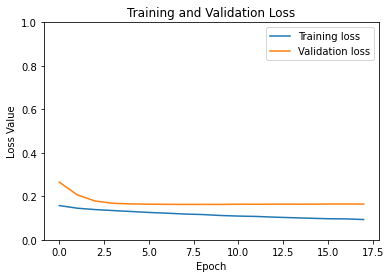

In [222]:
# Plot the loss of the model
loss = teeth_model.history['loss']
val_loss = teeth_model.history['val_loss']

plt.figure()
plt.plot(teeth_model.epoch, loss, label='Training loss')
plt.plot(teeth_model.epoch, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [226]:
# Evaluate model performance on the test set after loading the model
teeth_model = keras.models.load_model('teeth_segmentation.keras', custom_objects={'focal_tversky_loss': focal_tversky_loss})
test_teeth_model = teeth_model.evaluate(test_orig, tf.cast(test_teeth, 'float32'))

4/4 [==============================] - 3s 484ms/step - loss: 0.1591 - precision_4: 0.8660 - recall_4: 0.9359 - mean_io_u_4: 0.8750


## Abnormality Model

In [178]:
def unet_model(dropout):
  # Extract decoder path
  down0 = base.get_layer('input_1').output
  down1 = base.get_layer('conv1_conv').output
  down2 = base.get_layer('conv2_block3_1_relu').output
  down3 = base.get_layer('conv3_block4_1_relu').output
  x = base.get_layer('conv4_block6_1_relu').output 
  conv6 = up_block(256, down3, x, max_norm(3), max_norm(3))
  layers.Dropout(dropout)(conv6)
  conv7 = up_block(128, down2, conv6, max_norm(3), max_norm(3))
  layers.Dropout(dropout)(conv7)
  conv8 = up_block(64, down1, conv7, max_norm(3), max_norm(3))
  layers.Dropout(dropout)(conv8)
  conv9 = up_block(32, down0, conv8, max_norm(3), max_norm(3))
  layers.Dropout(dropout)(conv9)
  outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv9)

  model = keras.Model(inputs, outputs)
  return model

# Model object for abnormality detection
model_ab = unet_model(0.1)

In [ ]:
# Compile and train the model for tooth detection
#keras.backend.clear_session()
base.trainable = True
opt = keras.optimizers.Nadam(learning_rate=0.001)
model_ab.compile(optimizer=opt, loss=focal_tversky_loss, metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.MeanIoU(num_classes=2)])
# Save best model
callback = [
    keras.callbacks.ModelCheckpoint("abnormality_segmentation.keras", 
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=20)

]

# Fit the model
ab_model = model_ab.fit(sub_train_orig, tf.cast(train_ab, 'float32'),
                        epochs=64,
                        batch_size=32,
                        callbacks=callback,
                        validation_data=(sub_val_orig, tf.cast(val_ab, 'float32')))

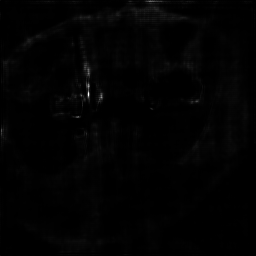

In [141]:
array_to_img(model_ab.predict(sub_val_orig)[2])

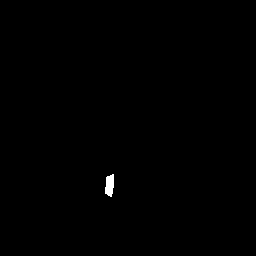

In [142]:
array_to_img(val_ab[2])